In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
%matplotlib notebook
import matplotlib as mpl
import matplotlib.patches as patches
from datetime import datetime

import matplotlib.animation as animation
from matplotlib import colors

## Uses heading, speed, and lag time to determine the correct lat lon coordinates

In [2]:
df = pd.read_csv('FLO_L3_20170502.csv', skiprows=[1])
# filters out all the values that are -9999
df.replace(-9999, np.NaN, inplace=True)
df = df[['Lat', 'Lon', 'secDay', 'Speed (m/s)', 'Heading']]
df.dropna(inplace=True)

In [3]:
df['Heading (rad)'] = df['Heading'].apply(np.deg2rad)

In [4]:
df.tail()

,Lat,Lon,secDay,Speed (m/s),Heading,Heading (rad)
661,43.727887,-70.202390,62588.0,2.9,278.0,4.852015
662,43.727905,-70.203096,62608.0,2.8,269.0,4.694936
663,43.727881,-70.203748,62628.0,2.2,267.0,4.660029
664,43.727882,-70.204172,62648.0,1.4,275.0,4.799655
665,43.727908,-70.204497,62668.0,1.4,276.0,4.817109


In [5]:
def get_coords_from_offsets(dn, de, coord, R=6378137):
    
    '''
    dn, de are the offset in meters in the north and east direction
    coord is a tuple containing (lon, lat)
    '''
    
    # cos is used for changes in latitude
    # sin is used for changes in longitude
        
    lon, lat = coord

    #Coordinate offsets in radians
    dLat = dn/R
    dLon = de/(R*np.cos(np.pi*lat/180))

    #//OffsetPosition, decimal degrees
    latO = lat - dLat * 180/np.pi
    lonO = lon - dLon * 180/np.pi 
    return (lonO, latO)

In [6]:
delay_time = 200 # delay time is 200 seconds

In [7]:
df['dn'] = df.apply(lambda row: row['Speed (m/s)'] * np.cos(row['Heading (rad)']) * delay_time, axis=1)
df['de'] = df.apply(lambda row: row['Speed (m/s)'] * np.sin(row['Heading (rad)']) * delay_time, axis=1)

In [8]:
df.tail()

,Lat,Lon,secDay,Speed (m/s),Heading,Heading (rad),dn,de
661,43.727887,-70.202390,62588.0,2.9,278.0,4.852015,80.720399,-574.355480
662,43.727905,-70.203096,62608.0,2.8,269.0,4.694936,-9.773348,-559.914709
663,43.727881,-70.203748,62628.0,2.2,267.0,4.660029,-23.027821,-439.396995
664,43.727882,-70.204172,62648.0,1.4,275.0,4.799655,24.403608,-278.934515
665,43.727908,-70.204497,62668.0,1.4,276.0,4.817109,29.267970,-278.466131


In [9]:
df[['Lon (corrected)', 'Lat (corrected)']] = df.apply(lambda row: get_coords_from_offsets(row['dn'], row['de'], (row['Lon'], row['Lat'])), axis=1).apply(pd.Series)

In [10]:
df = pd.read_csv('FLO_L3_CascoBay20171219_revised.csv', skiprows=[1])
# filters out all the values that are -9999
df.replace(-9999, np.NaN, inplace=True)
df = df[['Lat', 'Lon', 'secDay', 'Speed (m/s)', 'Heading']]
df.dropna(inplace=True)

In [11]:
def correct_coords(df, delay_time=100, clean_data=True):
    
    if clean_data:
        df[['Lat', 'Lon', 'Speed (m/s)', 'Heading']] = df.loc[:, ['Lat', 'Lon', 'Speed (m/s)', 'Heading']].replace(-9999, np.NaN)
        df.dropna(inplace=True)
    
    df['Heading (rad)'] = df['Heading'].apply(np.deg2rad)
    df['dn'] = df.apply(lambda row: row['Speed (m/s)'] * np.cos(row['Heading (rad)']) * delay_time, axis=1)
    df['de'] = df.apply(lambda row: row['Speed (m/s)'] * np.sin(row['Heading (rad)']) * delay_time, axis=1)
    df[['Lon (corrected)', 'Lat (corrected)']] = df.apply(lambda row: get_coords_from_offsets(row['dn'], row['de'], (row['Lon'], row['Lat'])), axis=1).apply(pd.Series)
    return df

In [12]:
df = correct_coords(df)
df.tail()

,Lat,Lon,secDay,Speed (m/s),Heading,Heading (rad),dn,de,Lon (corrected),Lat (corrected)
8254,43.725975,-70.173767,73748,4.32096,273.5,4.773476,26.378830,-431.290054,-70.168406,43.725738
8255,43.725980,-70.173883,73750,4.62960,273.7,4.776966,29.875877,-461.995015,-70.168140,43.725712
8256,43.725985,-70.173983,73752,5.14400,272.4,4.754277,21.540836,-513.948784,-70.167594,43.725791
8257,43.725988,-70.174117,73754,5.60696,272.6,4.757768,25.434846,-560.118803,-70.167154,43.725760
8258,43.725993,-70.174250,73756,6.06992,271.9,4.745550,20.124928,-606.658285,-70.166709,43.725812


In [13]:
df['Heading'].describe()

count    8259.000000
mean      176.559777
std       101.088927
min         0.100000
25%       101.300000
50%       165.000000
75%       273.300000
max       359.900000
Name: Heading, dtype: float64

In [14]:
df['Lat (corrected)'].describe()

count    8259.000000
mean       43.721644
std         0.001009
min        43.718206
25%        43.721040
50%        43.721619
75%        43.722505
max        43.725812
Name: Lat (corrected), dtype: float64

## Inputs the changes

In [15]:
filenames = ['FLO_L3_20170317.csv', 'FLO_L3_20170502.csv', 'FLO_L3_20171219_CascoBay_Dec2017_2sec.csv',
        'FLO_L3_CascoBay20171219_revised.csv', 'FLO_L3_CascoBay20180328.csv', 'FLO_L3_CascoBay20180507.csv']

In [18]:
# for file in filenames:
#     print(file)
#     df = pd.read_csv(file, skiprows=[1])
#     df = correct_coords(df, delay_time=100)
#     df.to_csv(file[:-4] + '_corrected.csv', index=False)

## LAT LON boundary

In [19]:
def get_boundary_box(corners, box_length=300, R=6378137):
    '''
    Corners follow the order NW, NE, SE, SW, (longitude, latitude)
    
    returns: upperbound, lower bound, right bound, left bound
    '''
    northmost = max(corners, key=lambda x: x[0])
    southmost = min(corners, key=lambda x: x[0])
    eastmost = max(corners, key=lambda x: x[1])
    westmost = min(corners, key=lambda x: x[1])  
    
    def get_coords_from_offsets(dn, de, coord):
        
        lon, lat = coord
        
        #Coordinate offsets in radians
        dLat = dn/R
        dLon = de/(R*np.cos(np.pi*lat/180))

        #//OffsetPosition, decimal degrees
        latO = lat + dLat * 180/np.pi
        lonO = lon + dLon * 180/np.pi 
        return (lonO, latO)
    
    # offsets in meters for north
    dn = box_length
    de = 0
    
    _, north_lat = get_coords_from_offsets(dn, de, northmost)
    
    # offsets in meters for south
    dn = box_length * -1
    de = 0
    
    _, south_lat = get_coords_from_offsets(dn, de, southmost)
    
    # offsets in meters for east
    dn = 0
    de = box_length
    
    east_lon, _ = get_coords_from_offsets(dn, de, eastmost)
    
    # offsets in meters for east
    dn = 0
    de = -box_length
    
    west_lon, _ = get_coords_from_offsets(dn, de, westmost)
    
#     corners = [(west_lon, north_lat), (east_lon, north_lat), (west_lon, south_lat), (east_lon, south_lat)]
    
    return [north_lat, south_lat, east_lon, west_lon]

In [20]:
NW = (-70.14655, 43.72273)
NE = (-70.14619, 43.72253)
SE = (-70.14876, 43.72015)
SW = (-70.14911, 43.72035)
corners = [NW, NE, SE, SW]
boundary = get_boundary_box(corners, box_length=100)
boundary

[43.72342831528412,
 43.719451684715885,
 -70.145306989100888,
 -70.150002957372038]

# Differences in the corrected lons and lats

In [34]:
filenames = ['FLO_L3_20170317.csv', 'FLO_L3_20170502.csv', 'FLO_L3_20171219_CascoBay_Dec2017_2sec.csv',
             'FLO_L3_CascoBay20180328.csv', 'FLO_L3_CascoBay20180507.csv']
filenames = [file[:-4] + '_corrected.csv' for file in filenames]

In [22]:
df = pd.read_csv(filenames[1], skiprows=[1])

# bounds df
df = df[(df['Lat'] < boundary[0]) & 
        (df['Lat'] > boundary[1]) & 
        (df['Lon'] < boundary[2]) & 
        (df['Lon'] > boundary[3])]

# plt.figure()
# plt.scatter(df['Lat'], df['Lon'], c='grey', s=3)
# plt.scatter(df['Lat (corrected)'], df['Lon (corrected)'], c='blue', s=3)

In [23]:
# sort by time order 
df = df.sort_values(['secDay'])

n = len(df)
speed = 2

vmin = df['sw pCO2 (uatm)'].min()
vmax = df['sw pCO2 (uatm)'].max()

In [39]:
def update(curr):
    # check if animation is at the last frame, and if so, stop the animation a
    
    if curr == int(n / speed):
        a.event_source.stop()
           
    curr *= speed
    
    plt.cla()
    plt.gca().set_title('Lag time: 200 seconds')
    plt.gca().set_ylabel('Longitude')
    plt.gca().set_xlabel('Latitude')
    
    plt.gca().set_xlim(-70.155, -70.140)
    plt.gca().set_ylim(43.716, 43.730)
    
    trailing_pts = 10
    
    if curr <= trailing_pts:
        curr_prev = 0
    else:
        curr_prev = curr - trailing_pts
        
        
#     # creates a color array
#     data = df['sw pCO2 (uatm)']
#     norm = colors.Normalize()
#     norm.autoscale(data)
#     rgba_colors = plt.cm.jet(norm(data.values))
    
#     # varies alphas so only k points are shown with 
#     rgba_colors[:, 3] = 0.1
#     rgba_colors[curr_prev:curr, 3] = 1
    
    plt.scatter(x=df['Lon'][:curr], y=df['Lat'][:curr], 
                c='grey', s=20, alpha=0.5)
    
    plt.scatter(x=df['Lon (corrected)'][:curr], y=df['Lat (corrected)'][:curr], 
                c='blue', s=20, alpha=0.5)

    plt.annotate('time: {}'.format(curr), [-70.143,43.728])
    plt.legend(loc=2)
    plt.tight_layout()

<IPython.core.display.Javascript object>


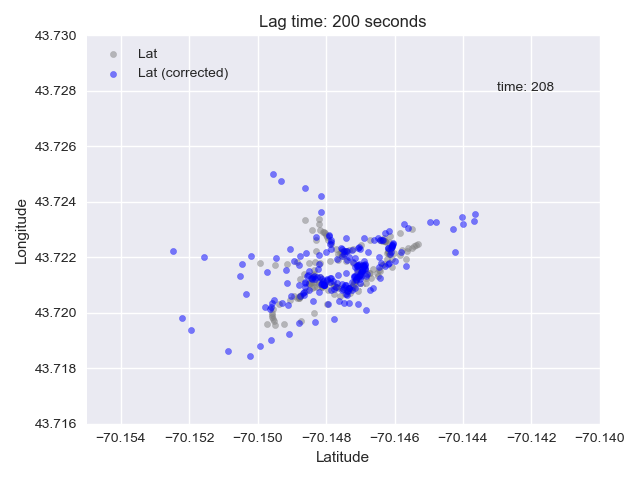

In [42]:
fig, ax = plt.subplots()

ax.set_title('Lag time: 200 seconds')
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')

plt.tight_layout()

a = animation.FuncAnimation(fig, update, interval=100, frames=500, repeat=False)

In [31]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [35]:
dates = [
    '2017-03-17',
    '2017-05-02',
    '2017-12-19',
    '2018-03-28',
    '2018-05-07'
]

<IPython.core.display.Javascript object>


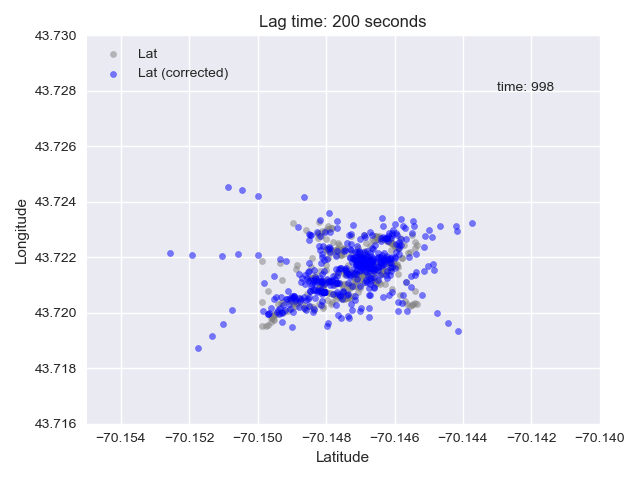

<IPython.core.display.Javascript object>


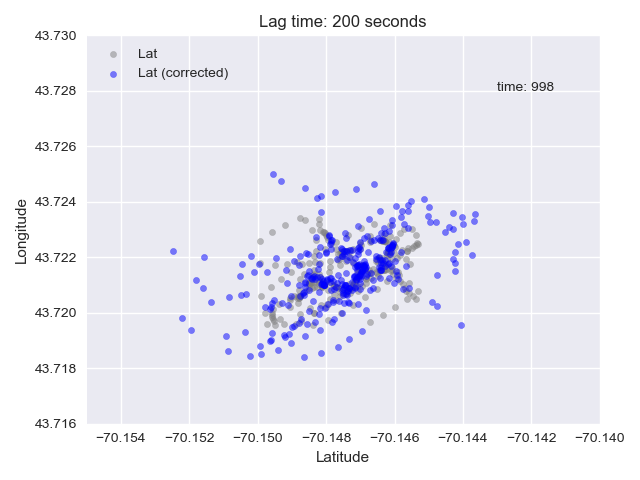

<IPython.core.display.Javascript object>


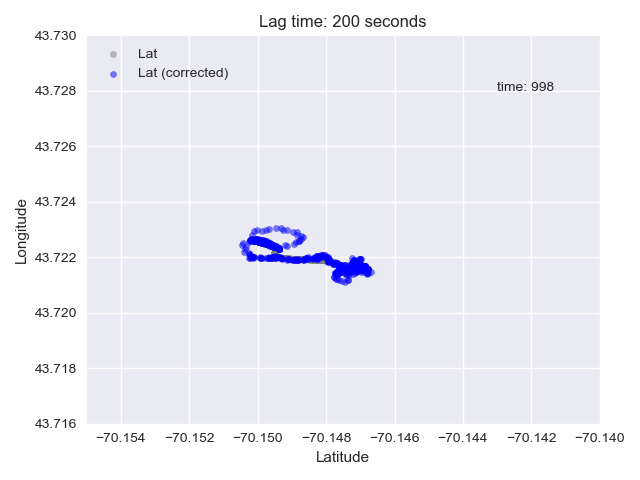

<IPython.core.display.Javascript object>


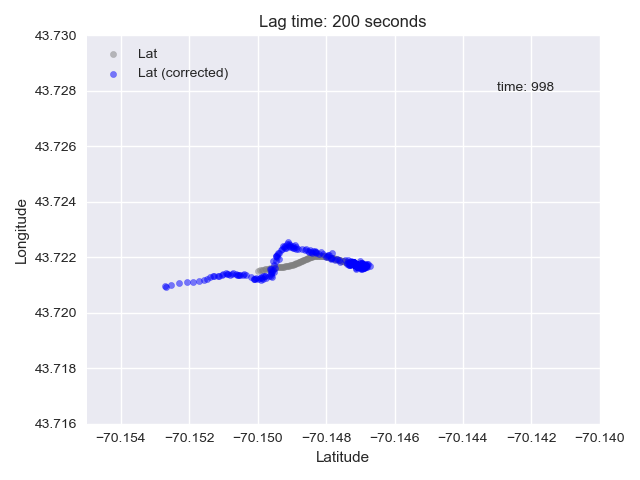

<IPython.core.display.Javascript object>


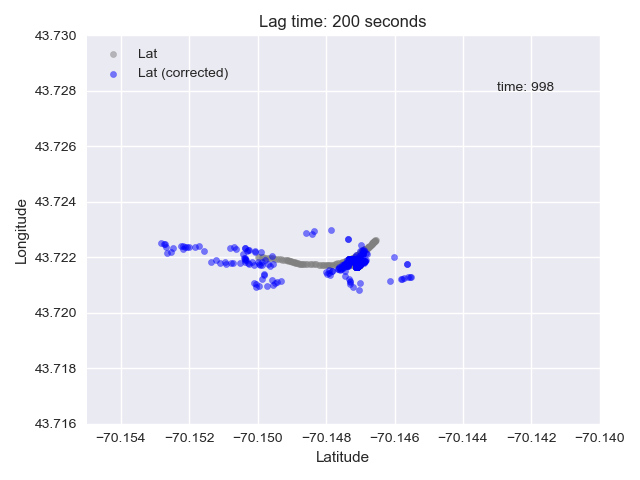

In [44]:
for file, date in zip(filenames, dates):
    df = pd.read_csv(file, skiprows=[1])

    # bounds df
    df = df[(df['Lat'] < boundary[0]) & 
            (df['Lat'] > boundary[1]) & 
            (df['Lon'] < boundary[2]) & 
            (df['Lon'] > boundary[3])]

    # plt.figure()
    # plt.scatter(df['Lat'], df['Lon'], c='grey', s=3)
    # plt.scatter(df['Lat (corrected)'], df['Lon (corrected)'], c='blue', s=3)
    
    # sort by time order 
    df = df.sort_values(['secDay'])

    n = len(df)
    speed = 2
    
    fig, ax = plt.subplots()

    ax.set_title('Lag time: 200 seconds')
    ax.set_ylabel('Longitude')
    ax.set_xlabel('Latitude')

    plt.tight_layout()

    a = animation.FuncAnimation(fig, update, interval=100, frames=500, repeat=False)
    
    a.save('Graphs and Visualization/{}_corrected_latlon.mp4'.format(date), writer=writer)